# Bark Beetles: Predicting the Plague - Model Training

#### Modeling the spruce bark beetle infestation in short-time intervals for locally distinct spatial administrative units within Saxony on the basis of the infestation development and the weather pattern up to the time of forecast


**Author**
Yannic Holländer

**Abstract**
In this notebook prediction models for the amount of infested wood are trained. The models will make predictions for one timeframe, one forestry district and for one ownership group at a time (analogous to the dataset). Mutiple approaches are compared, the models are evaluated and the best model is chosen for deployment.

# 1 Setup

In [1]:
# imports 
import numpy as np
import pandas as pd
import plotnine as p9
import pickle
from matplotlib import rcParams

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV)
from sklearn.model_selection import (
    cross_val_predict, cross_val_score, cross_validate)
from sklearn.metrics import (
    mean_squared_error, explained_variance_score, mean_absolute_error)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor)
from xgboost import XGBRegressor

# settings
# diplay all columns of a dataframe
pd.options.display.max_columns= None

# set default font (used in p9.theme_seaborn())
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

# defining custom colors, used whenever possible to match presentation
mycolors = ['#447672', '#ee6d71', '#8fc0e0', '#ffb947', 
            '#4e445f', '#d1d882', '#9D7558', '#a7d8d4', 
            '#ffaeac', '#b0b7bd', '#fce4c9', '#bfb4d2', 
            '#5b83a8', '#575757']

# make custom plotnine theme
mythemewide = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text=p9.element_text(size=17),
                 figure_size = (15, 7.5)
                 subplots_adjust={'hspace': 0.31, 'wspace': 0.31}
             )
            )

In [ ]:
###############################################################################

In [ ]:
# read dataset
data = pd.read_csv('barkbeetle_dataset.csv')

# reestablish timestamps
data['timestamp'] = pd.to_datetime(data['timestamp'])

# remove pre 2006 and post feb2020 
data = data[data['timestamp'].isin(
    pd.date_range(start='2006-01-01', end='2020-02-29', freq='M')
)]

# 2 Preparing evaluation functions

To allow for a simple and clear training process, all of the used functions will be defined preemptively in this chapter.

## 2.1 Preparation of data for pipelines

Some steps need to be taken before the 

In [3]:
def results_setup(X_train, X_val, X_test):    
    # remove and save ids and timestamps from the sets
    # can be used to show model predictions later 
    id_train, ts_train = X_train.pop('id'), X_train.pop('timestamp')
    id_val, ts_val = X_val.pop('id'), X_val.pop('timestamp')
    id_test, ts_test = X_test.pop('id'), X_test.pop('timestamp')
    
    results_df = pd.concat([X_train, X_val, X_test])
    results_df['id'] = pd.concat([id_train, id_val, id_test])    
    results_df['timestamp'] = pd.concat([ts_train, ts_val, ts_test])
    results_df['true value'] = pd.concat([y_train, y_val, y_test])   
    results_df['set'] = ['train set'] * X_train.shape[0] + ['validation set'] * X_val.shape[0] + ['test set'] * X_test.shape[0]
    
    return results_df

In [7]:
# TODO: diese Funktion als custom pipeline

def month_num_encoder(X_train, y_train, X_val, X_test):
    '''
    TODO: documentation
    '''
        
    # get a factor for every timeframe
    # factor = how much of the yearly infestation was observed in the respective timeframe
    
    # merge timeframe column from X_train with y_train (target)
    tf_y = pd.DataFrame({'timeframe': X_train['timeframe'], 'target': y_train})
    
    # group by timeframe and take the mean of target
    tf_y = tf_y.groupby('timeframe').mean()
    
    # get the sum of all groups
    total = tf_y['target'].sum()
    
    # make a dictionary that maps the timeframe to the ratio it contributes to the target on average
    transform_dict = tf_y['target'].map(lambda x: x/total).to_dict()
    print(transform_dict)
    # use these factors (one numerical feature) in train, val and test sets
    # instead of the timeframe feature (categorial with 8 categories)
    # since we only used the knowledge on our targets of the train set (y_train) there is no data leakage 
    
    new_X_train = X_train.copy()
    new_X_train['timeframe'] = new_X_train['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_train.columns = ['timeframe_enc' if x=='timeframe' else x for x in new_X_train.columns]
    
    new_X_val = X_val.copy()
    new_X_val['timeframe'] = new_X_val['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_val.columns = ['timeframe_enc' if x=='timeframe' else x for x in new_X_val.columns]
    
    new_X_test = X_test.copy()
    new_X_test['timeframe'] = new_X_test['timeframe'].map(lambda x: transform_dict.get(x))
    new_X_test.columns = ['timeframe_enc' if x=='timeframe' else x for x in new_X_test.columns]
    
    return new_X_train, new_X_val, new_X_test

## 2.2 Fitting the pipelines

In [8]:
def crossvalscores(pipelines, X_train, y_train):
    '''
    TODO
    '''
    # Making predictions on the training set using cross validation
    # cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
    
    for pipe in pipelines:
        print(f'Cross validation scores for {pipe.steps[-1][1]}:')
        y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
        # Calculating the mean sqaured error, mean absolute error and explained variance for 
        print('-------------------------')
        print('MAE: {:.2f}'.format(mean_absolute_error(y_train, y_train_predicted)))
        print('RMSE: {:.2f}'.format(mean_squared_error(y_train, y_train_predicted, squared=False)))
        print('Explained Variance: {:.2f}'.format(explained_variance_score(y_train, y_train_predicted)))
        print('\n')

In [9]:
def randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val):
    '''
    
    '''
    # Fit the grid search objects
    print('Performing model optimizations...')
    best_mae = np.inf
    best_models = {}
    for idx, rs in enumerate(grids):
        print(f'\nEstimator: {grid_dict[idx]}')	
        # Fit grid search	
        rs.fit(X_train, y_train)
        # Best params
        print(f'Best params: {rs.best_params_}')
        # Best training data accuracy
        print(f'Best training MAE: {-rs.best_score_:.2f}') 
        # Predict on validation data with best params
        best_model = rs.best_estimator_    
        y_val_pred = best_model.predict(X_val)
        # Test data accuracy of model with best params
        print(f'Validation set MAE for best params: {mean_absolute_error(y_val, y_val_pred):.2f}')
        # save best result of search in best_models
        best_models[idx] = best_model
        # Track best (highest MAE) model from all estimators
        if mean_absolute_error(y_val, y_val_pred) < best_mae:
            best_mae = mean_absolute_error(y_val, y_val_pred)
            best_rs = rs
            best_reg = idx
    
    
    for idx, model in best_models.items():
    
        y_val_pred = model.predict(X_val)
        print(f'\n\nSummary of validation set errors')
        print(f'{grid_dict.get(idx)}:')
        print('-------------------------')
        print("MAE: {:.2f}".format(mean_absolute_error(y_val, y_val_pred)))
        print("RMSE: {:.2f}".format(mean_squared_error(y_val, y_val_pred, squared=False)))
        print("Explained Variance: {:.2f}\n".format(explained_variance_score(y_val, y_val_pred)))
    
    print(f'\nClassifier with best validation set MAE: {grid_dict[best_reg]}')
    
    return best_models

    # Save best grid search pipeline to file
    #dump_file = 'best_gs_pipeline.pkl'
    #joblib.dump(best_gs, dump_file, compress=1)
    #print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

## 2.3 Model Evaluation

In [10]:
def plot_results(results_df, best_models, grid_dict, X_train, X_val, y_train, y_val, path):
    # first, remove from results_df all test set values, as the 
    # test set will not be included until we found the final model
    results_df = results_df[results_df['set'] != 'test set'].reset_index(drop=True)

    scores = []
    for idx, model in best_models.items():
        name = grid_dict.get(idx)
        y_val_pred = model.predict(X_val) 
        y_train_pred = model.predict(X_train)
        
        # save the predictions so we can compare them in a later plot
        results_df[name] = np.concatenate([y_train_pred, y_val_pred])
        scores.append([name, 
                       mean_absolute_error(y_train, y_train_pred),
                       mean_squared_error(y_train, y_train_pred, squared=False),
                       explained_variance_score(y_train, y_train_pred),
                       'training set'
                      ])
            
        scores.append([name, 
                       mean_absolute_error(y_val, y_val_pred),
                       mean_squared_error(y_val, y_val_pred, squared=False),
                       explained_variance_score(y_val, y_val_pred),
                       'validation set'
                      ])
    
    scores = pd.DataFrame(scores, columns=['model', 'Mean Absolute Error', 'Root Mean Squared Error', 'Explained Variance', 'set'])
    
    # plot comparison of model scores

    draw = pd.melt(scores, id_vars=['model','set'])
    
    s=(p9.ggplot(draw)
     + p9.geom_col(p9.aes('set', 'value', fill='model'), position='dodge')
     + p9.facet_wrap('variable', scales='free_y')
     + p9.scale_fill_manual(mycolors[:5])
     + p9.ylab('metric value') + p9.xlab('')
     + mytheme_wide
    )
    s.draw()
    s.save(fr'{path}scores.png', verbose=False)
    
    ###########################################
    # plot predictions
    top_models = list(scores[scores['set'] == 'validation set'].sort_values('Mean Absolute Error', ascending=True)['model'])
    
    # id_subset = np.random.choice(results_df['id'].unique(), 5, replace=False)
    id_subset = [
        'Vogtlandkreis-Schöneck-SW',
        'Sächsische Schweiz-Osterzgebirge-Sebnitz-NSW',
        'Erzgebirgskreis-Zwönitz-NSW',
        'Kreisfreie Stadt Dresden-Dresden-SW'
    ]
    
    for ID in results_df['id'].unique():
        draw = results_df[results_df['id'] == ID]
        draw = pd.melt(draw, id_vars=['id', 'timestamp', 'set'], value_vars=[
            'true value', 
            top_models[0], 
            #top_models[1], top_models[2]
        ])
        validation_ts = draw[draw['set'] == 'validation set']['timestamp']
        
        p=(p9.ggplot(draw)
            + p9.geom_vline(xintercept=validation_ts, color=mycolors[0], size=.3, linetype='dashed', alpha=1)
            + p9.geom_line(p9.aes('timestamp', 'value', color='variable'))
            + p9.scale_color_manual([
                mycolors[1], 
                #mycolors[1], mycolors[2], 
                'black'], name='model')
            + p9.xlab('date') + p9.ylab(r'infested wood in solid m$^3$')
            + p9.labels.ggtitle(ID)
            + mytheme_wide
        )
        p.save(fr'{path}{ID}.png', verbose=False)
        
        if ID in id_subset:
            p.draw()
            
    ###########################################
    # importances
    
        
    importances = {}
    for idx, model in best_models.items():
        
        if type(best_models[idx]['regressor']) in [type(XGBRegressor()), 
                                                   type(RandomForestRegressor()), 
                                                   type(GradientBoostingRegressor())]:
            importances[idx] = model['regressor'].feature_importances_
        elif type(model['regressor']) == type(LinearRegression()):
            # best approximation in linear regression is coef_ (take absolute)
            importances[idx] = abs(model['regressor'].coef_)
        else:
            continue
        
        if type(model[1]) == type(PCA()):
            importances_names = range(len(model['regressor'].feature_importances_))
        else:
            importances_names = X_train.columns

    
    draw = pd.melt(pd.DataFrame(list(importances.values()), 
                                columns=importances_names, 
                                index=[grid_dict.get(idx) for idx in importances.keys()]), 
                   ignore_index=False)
    i=(
        p9.ggplot(draw)
        + p9.geom_col(p9.aes('reorder(variable, -value)', 'value', fill=draw.index), position='dodge')
        + p9.scale_fill_manual([mycolors[0], mycolors[2], mycolors[4]], name='model') # each color manually so they match the other plots
        + p9.xlab('feature') + p9.ylab('importance')
        + mytheme_wide
        + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    )
    i.draw()
    i.save(fr'{path}importances.png', verbose=False)

_______________________________________________________________________________________________________________________________________

# 3 Baseline Model

## 3.1 Feature selection

In [9]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    'timestamp', 'id', 
    'area_endangered', 'timeframe',
    'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo',
    'KWK', 'KWK_rollsr',
    'demolition_wood'
]]

## 3.2 train-val-test split

In [10]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# make validation and test set according to val_ratio and test_ratio
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + val_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 3.3 Preparations

In [11]:
# remove id and timestamp and set up results dataframe
base_results_df = results_setup(X_train, X_val, X_test)

In [12]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_endangered            9515 non-null   float64
 1   timeframe                  9515 non-null   float64
 2   prev_infested_wood         9513 non-null   float64
 3   prev_infested_wood_rollyr  9500 non-null   float64
 4   prev_infested_wood_ofo     9513 non-null   float64
 5   KWK                        9515 non-null   float64
 6   KWK_rollsr                 9502 non-null   float64
 7   demolition_wood            9511 non-null   float64
dtypes: float64(8)
memory usage: 669.0 KB


## 3.4 Pipeline Setup

In [14]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo', 'KWK', 'KWK_rollsr', 'demolition_wood']


In [15]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) # Standardscaler not needed if we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [16]:

# Building a full pipeline with our preprocessor and a Regressor
pipe_base = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

pipelines = [pipe_base]
grid_dict = {0: 'Linear Regression'}

## 3.5 Model Training

In [17]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for LinearRegression(n_jobs=-1):
-------------------------
MAE: 288.15
RMSE: 1573.32
Explained Variance: 0.56




In [18]:
base_model = {0: pipe_base.fit(X_train, y_train)}

## 3.6 Model Evaluation

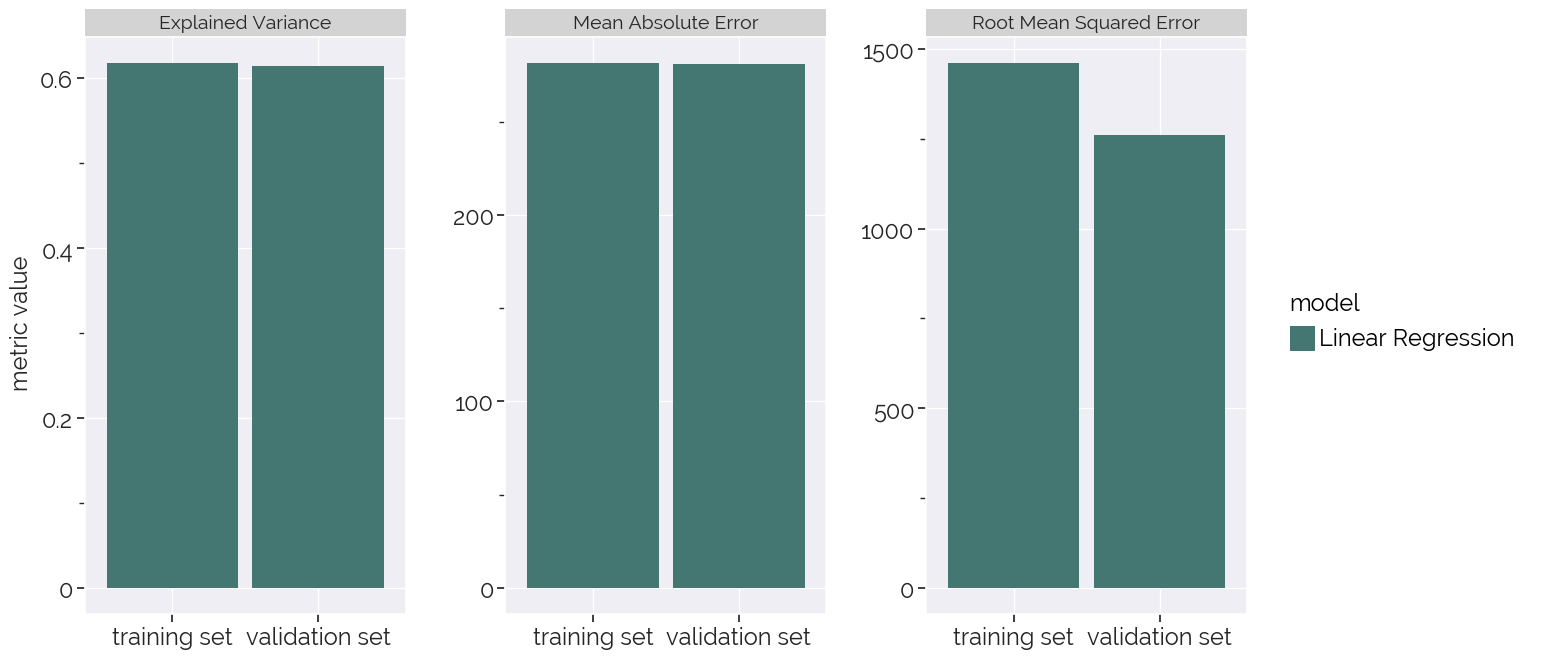

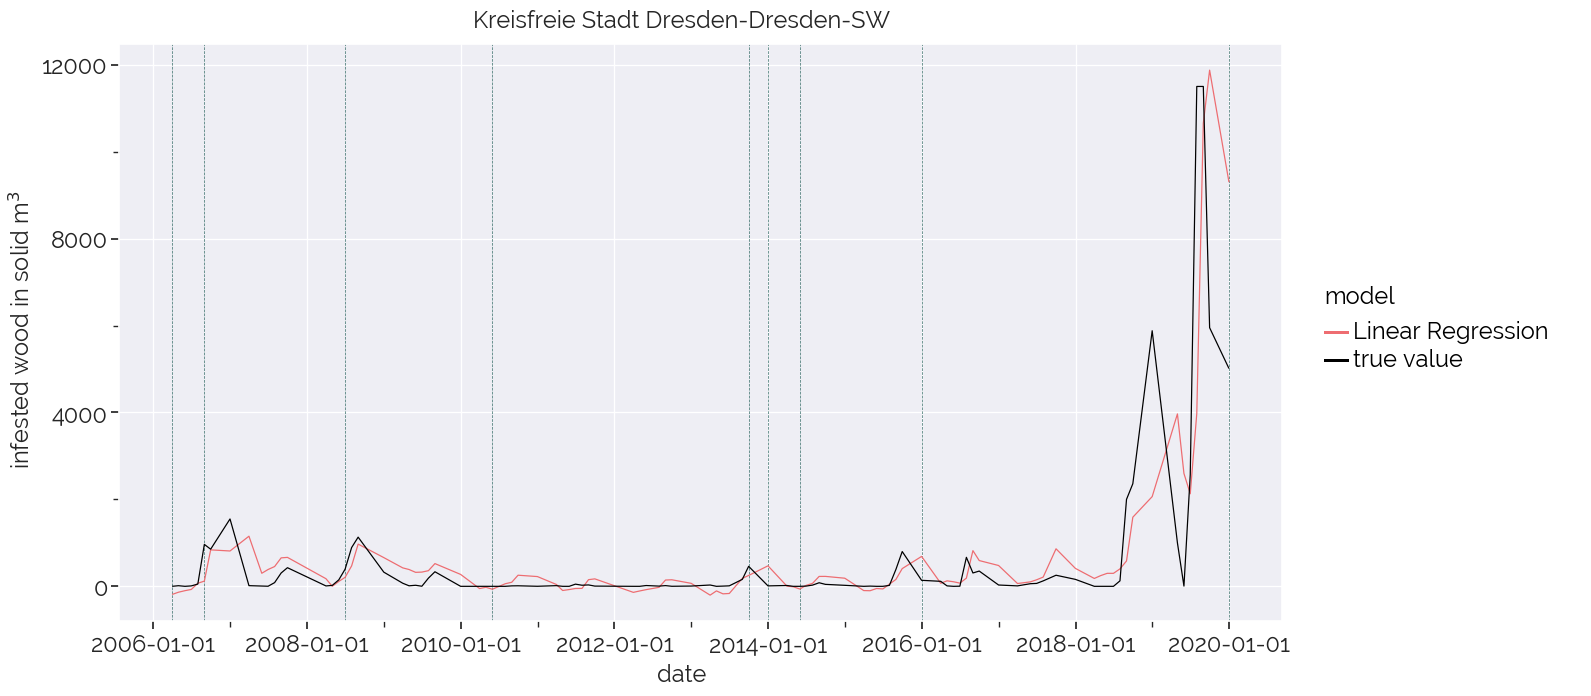

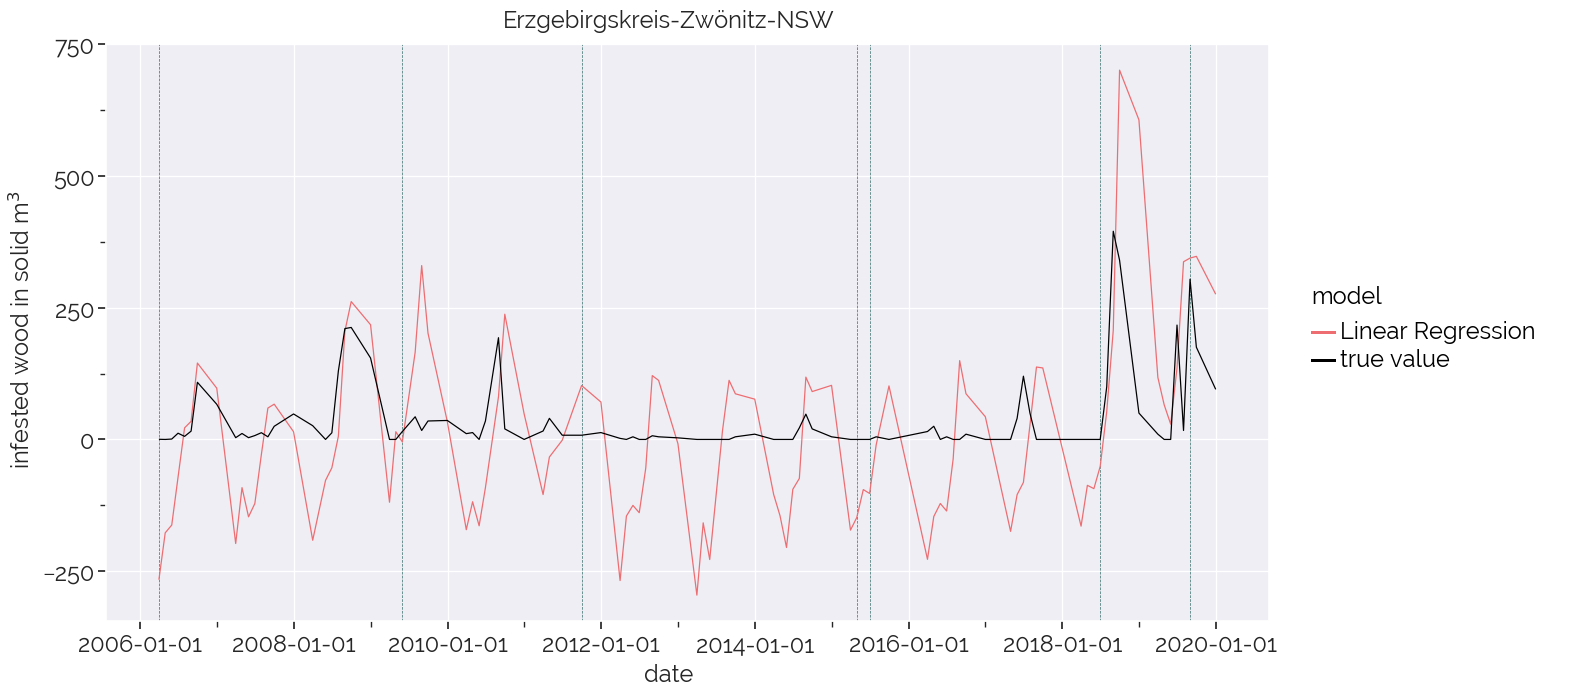

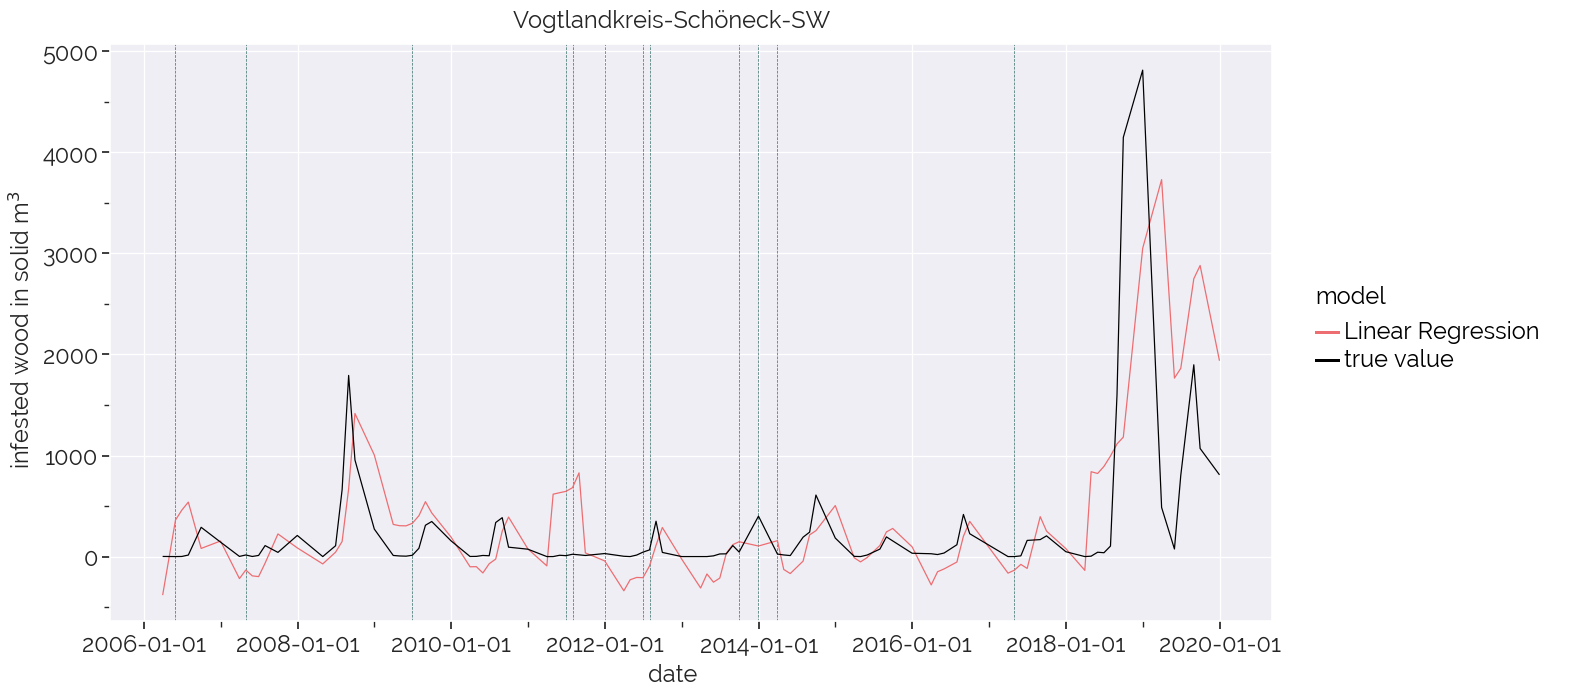

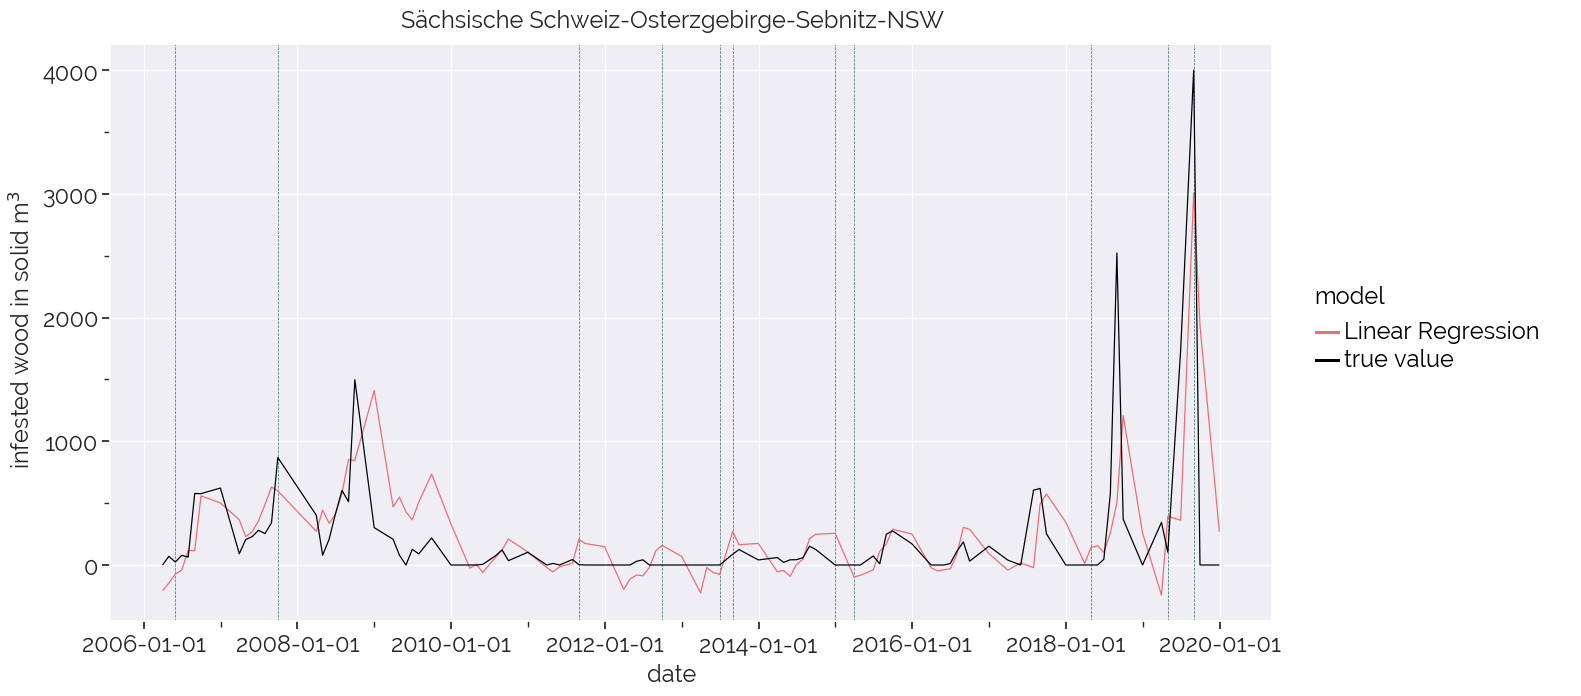

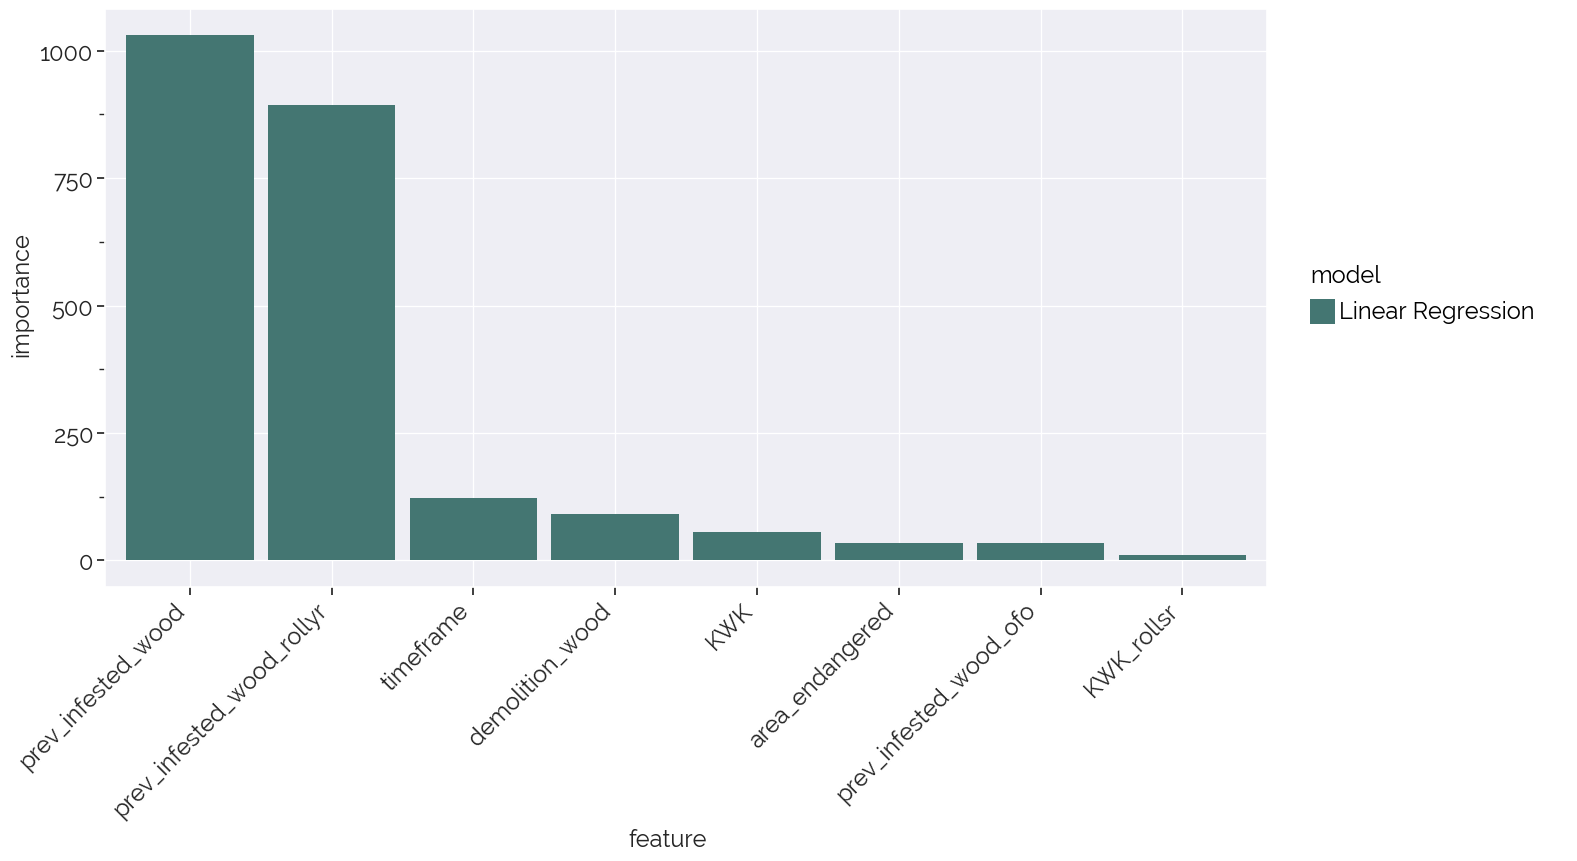

In [19]:
plot_results(base_results_df, base_model, grid_dict, X_train, X_val, y_train, y_val, r'pred_baseline/')

# 4 Model with liberal selection approach & PCA
## 4.1 Feature selection

In [20]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    'timestamp', 'id', 
    'area_endangered', 'timeframe', 
    'centroid_ycoord', 'centroid_xcoord',
    'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo',
    'demolition_wood', 
    'prev_disposed_wood','prev_disposed_wood_rollyr',
    'disposing_rate_demolition', 'disposing_rate_infested_yr',
    'RRK', 'TM0', 'RGK', 'KWK', 'RF0',
    'RRK_rollsr', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'RF0_rollsr',
    'RRK_rollwr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'RF0_rollwr'
]]

## 4.2 train-val-test split

In [21]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# make validation and test set according to val_ratio and test_ratio
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + val_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 4.3 Preparations

In [22]:
# remove id and timestamp and set up results dataframe
lib_results_df = results_setup(X_train, X_val, X_test)

In [23]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   area_endangered             9515 non-null   float64
 1   timeframe                   9515 non-null   float64
 2   centroid_ycoord             9515 non-null   float64
 3   centroid_xcoord             9515 non-null   float64
 4   prev_infested_wood          9513 non-null   float64
 5   prev_infested_wood_rollyr   9500 non-null   float64
 6   prev_infested_wood_ofo      9513 non-null   float64
 7   demolition_wood             9511 non-null   float64
 8   prev_disposed_wood          9513 non-null   float64
 9   prev_disposed_wood_rollyr   9500 non-null   float64
 10  disposing_rate_demolition   9511 non-null   float64
 11  disposing_rate_infested_yr  9500 non-null   float64
 12  RRK                         9515 non-null   float64
 13  TM0                         95

## 4.4 Pipeline Setup

In [25]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe', 'centroid_ycoord', 'centroid_xcoord', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo', 'demolition_wood', 'prev_disposed_wood', 'prev_disposed_wood_rollyr', 'disposing_rate_demolition', 'disposing_rate_infested_yr', 'RRK', 'TM0', 'RGK', 'KWK', 'RF0', 'RRK_rollsr', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'RF0_rollsr', 'RRK_rollwr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'RF0_rollwr']


In [26]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) # Standardscaler not needed if we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [27]:

# Building a full pipeline with our preprocessor and a Regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', XGBRegressor(
        objective='reg:squarederror'
    ))
])

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', RandomForestRegressor(
        criterion='mae', 
        random_state=0, 
        n_jobs=-1
    ))
])

pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', GradientBoostingRegressor(
        criterion='mae',  
        random_state=0
    ))
])

pipe_knr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', KNeighborsRegressor(
        n_jobs=-1
    ))
])

pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', SVR(
        max_iter=50000
    ))
])

pipelines = [pipe_xgbr, pipe_rfr, pipe_gbr, pipe_knr, pipe_svr]

In [28]:
#####################################################################
# optimizing - defining parameter space for search
search_params_xgbr = [{       
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__learning_rate'    : [0.01, 0.015, 0.02, 0.05, 0.10] ,
    'regressor__max_depth'        : [8, 10, 12, 14, 16],
    'regressor__subsample'        : [0.45, 0.55, 0.65, 0.75],
    'regressor__min_child_weight' : [1, 2, 3, 4],
    'regressor__gamma'            : [0.0, 0.05, 0.1, 0.2 , 0.3],
    'regressor__colsample_bytree' : [0.5, 0,6, 0.7, 1],
    'regressor__colsample_bylevel': [0.75, 1],
    'regressor__colsample_bynode' : [0.75, 1],
    'regressor__n_estimators'     : [75, 100, 125, 175],
}]

search_params_rfr = [{    
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__max_depth'        : [10, 12, 15, 17, 20],
    'regressor__min_samples_split': [2, 5, 8],
    'regressor__max_features'     : ['log2', 'sqrt', None],
    'regressor__bootstrap'        : [True, False],
    'regressor__min_samples_leaf' : [2, 3, 4, 5, 6],
    'regressor__n_estimators'     : range(75,200,25),
}]
 
search_params_gbr = [{ 
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__learning_rate'    : [0.05, 0.1, 0.15, 0.2, 0.25],
    'regressor__min_samples_split': np.linspace(0.01, 0.15, 8),
    'regressor__min_samples_leaf' : np.linspace(0.01, 0.15, 8),
    'regressor__max_depth'        : [5, 10, 15, 20, 25],
    'regressor__max_features'     : ['log2','sqrt', None],
    'regressor__subsample'        : [0.8, 0.9, 1.0, 1.1, 1.2],
    'regressor__n_estimators'     : range(125,326,50),    
}]

search_params_knr = [{
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__metric'           : ['manhattan', 'euclidean', 'minkowski'],
    'regressor__n_neighbors'      : range(3, 81, 1),
    'regressor__weights'          : ['uniform', 'distance'],   
}]

search_params_svr = [{ 
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__kernel'           : ['rbf', 'sigmoid', 'poly', 'linear'],
    'regressor__degree'           : [2, 3],
    'regressor__gamma'            : np.linspace(0.0001, 10, 25),
    'regressor__C'                : np.linspace(0.1, 100, 25),
}]


In [29]:
scoring = 'neg_mean_absolute_error'
cv = 3
n_jobs=-1
verbose=1
random_state=0

# specify search hyperparameters
rs_xgbr = RandomizedSearchCV(pipe_xgbr, 
                             param_distributions=search_params_xgbr, 
                             cv=cv, 
                             scoring=scoring, 
                             verbose=verbose, 
                             n_jobs=n_jobs, 
                             random_state=random_state, 
                             n_iter=4000) 

rs_rfr = RandomizedSearchCV(pipe_rfr, 
                            param_distributions=search_params_rfr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=40)

rs_gbr = RandomizedSearchCV(pipe_gbr, 
                            param_distributions=search_params_gbr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=40)

rs_knr = RandomizedSearchCV(pipe_knr, 
                            param_distributions=search_params_knr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=100)

rs_svr = RandomizedSearchCV(pipe_svr, 
                            param_distributions=search_params_svr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=300)

grids = [rs_xgbr, rs_rfr, rs_gbr, rs_knr, rs_svr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'XGBoost', 1: 'Random Forest', 
             2: 'Gradient Boosted Trees', 3: 'KNeighbors', 
             4: 'Support Vector Regression'}

## 4.5 Model Training

In [30]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for XGBRegressor(objective='reg:squarederror'):
-------------------------
MAE: 242.82
RMSE: 1793.93
Explained Variance: 0.42


Cross validation scores for RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=0):
-------------------------
MAE: 253.31
RMSE: 2025.13
Explained Variance: 0.26


Cross validation scores for GradientBoostingRegressor(criterion='mae', random_state=0):
-------------------------
MAE: 241.03
RMSE: 2164.06
Explained Variance: 0.16


Cross validation scores for KNeighborsRegressor(n_jobs=-1):
-------------------------
MAE: 209.46
RMSE: 1686.29
Explained Variance: 0.49


Cross validation scores for SVR(max_iter=50000):
-------------------------
MAE: 257.87
RMSE: 2370.29
Explained Variance: 0.00




In [31]:
best_models_lib = randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val)

Performing model optimizations...

Estimator: XGBoost
Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

Best params: {'regressor__subsample': 0.75, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 16, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0.0, 'regressor__colsample_bytree': 1, 'regressor__colsample_bynode': 1, 'regressor__colsample_bylevel': 0.75, 'dim_red__n_components': 15}
Best training MAE: 201.32
Validation set MAE for best params: 188.68

Estimator: Random Forest
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 43.4min finished


Best params: {'regressor__n_estimators': 125, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 5, 'regressor__max_features': None, 'regressor__max_depth': 15, 'regressor__bootstrap': True, 'dim_red__n_components': 7}
Best training MAE: 207.62
Validation set MAE for best params: 195.33

Estimator: Gradient Boosted Trees
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  89 out of 120 | elapsed: 28.6min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 42.4min finished


Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 275, 'regressor__min_samples_split': 0.03, 'regressor__min_samples_leaf': 0.03, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20, 'regressor__learning_rate': 0.2, 'dim_red__n_components': 11}
Best training MAE: 223.90
Validation set MAE for best params: 234.63

Estimator: KNeighbors
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.8s finished


Best params: {'regressor__weights': 'uniform', 'regressor__n_neighbors': 13, 'regressor__metric': 'manhattan', 'dim_red__n_components': 15}
Best training MAE: 220.21
Validation set MAE for best params: 198.92

Estimator: Support Vector Regression
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  4.2min finished
C:\Users\Yannic\.conda\envs\python377\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best params: {'regressor__kernel': 'linear', 'regressor__gamma': 3.3334, 'regressor__degree': 2, 'regressor__C': 33.400000000000006, 'dim_red__n_components': 15}
Best training MAE: 215.31
Validation set MAE for best params: 220.12


Summary of validation set errors
XGBoost:
-------------------------
MAE: 188.68
RMSE: 1486.65
Explained Variance: 0.47



Summary of validation set errors
Random Forest:
-------------------------
MAE: 195.33
RMSE: 1370.85
Explained Variance: 0.54



Summary of validation set errors
Gradient Boosted Trees:
-------------------------
MAE: 234.63
RMSE: 1808.70
Explained Variance: 0.21



Summary of validation set errors
KNeighbors:
-------------------------
MAE: 198.92
RMSE: 1392.07
Explained Variance: 0.53



Summary of validation set errors
Support Vector Regression:
-------------------------
MAE: 220.12
RMSE: 1619.28
Explained Variance: 0.37


Classifier with best validation set MAE: XGBoost


## 4.6 Model Evaluation

In [ ]:
plot_results(lib_results_df, best_models_lib, grid_dict, X_train, X_val, y_train, y_val, r'pred_liberal/')

# 5 Model with frugal selection approach

## 5.1 Feature selection

In [11]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    'timestamp', 'id', 
    'area_endangered', 'timeframe',
    'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo',
    'RRK', 'TM0',
    'demolition_wood', 
    'RRK_rollsr'

]]

## 5.2 train-val-test split

In [12]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=1 - train_ratio, 
                                                    random_state=0)

# make validation and test set according to val_ratio and test_ratio
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + val_ratio), 
                                                random_state=0, 
                                                shuffle=False)  # shuffle already done in first split

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 5.3 Preparations

In [13]:
# remove id and timestamp and set up results dataframe
fru_results_df = results_setup(X_train, X_val, X_test)

In [14]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

{'01 Januar-März': 0.04695437961628093, '04 April': 0.01613466392797747, '05 Mai': 0.026238326902676162, '06 Juni': 0.048392631582756127, '07 Juli': 0.11820248134015453, '08 August': 0.2340321842232208, '09 September': 0.2396741387722562, '10 Oktober-Dezember': 0.2703711936346777}


In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_endangered            9515 non-null   float64
 1   timeframe_enc              9515 non-null   float64
 2   prev_infested_wood         9513 non-null   float64
 3   prev_infested_wood_rollyr  9500 non-null   float64
 4   prev_infested_wood_ofo     9513 non-null   float64
 5   RRK                        9515 non-null   float64
 6   TM0                        9515 non-null   float64
 7   demolition_wood            9511 non-null   float64
 8   RRK_rollsr                 9502 non-null   float64
dtypes: float64(9)
memory usage: 743.4 KB


## 5.4 Pipeline Setup

In [52]:
# Creating list for categorical predictors/features 
# Should not have any but we leave it in for robustness sake (TODO:remove)
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe_enc', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo', 'RRK', 'TM0', 'demolition_wood', 'RRK_rollsr']


In [53]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) # Standardscaler not needed if we use Decision Tree Based Models
])

# Pipeline for categorical features 
# don't have those for now but keep it in for robustness' sake
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [54]:

# Building a full pipeline with our preprocessor and a Regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror'
    ))
])

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        criterion='mae', 
        random_state=0, 
        n_jobs=-1
    ))
])

pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        criterion='mae',  
        random_state=0
    ))
])

pipe_knr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_jobs=-1
    ))
])

pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(
        max_iter=50000
    ))
])

pipelines = [pipe_xgbr, pipe_rfr, pipe_gbr, pipe_knr, pipe_svr]

In [55]:
#####################################################################
# optimizing - defining parameter space for search
search_params_xgbr = [{                 
    'regressor__learning_rate'    : [0.01, 0.015, 0.02, 0.05, 0.10] ,
    'regressor__max_depth'        : [8, 10, 12, 14, 16],
    'regressor__subsample'        : [0.45, 0.55, 0.65, 0.75],
    'regressor__min_child_weight' : [1, 2, 3, 4],
    'regressor__gamma'            : [0.0, 0.05, 0.1, 0.2 , 0.3],
    'regressor__colsample_bytree' : [0.5, 0,6, 0.7, 1],
    'regressor__colsample_bylevel': [0.75, 1],
    'regressor__colsample_bynode' : [0.75, 1],
    'regressor__n_estimators'     : [75, 100, 125, 175],
}]

search_params_rfr = [{    
    'regressor__max_depth'         : [10, 12, 15, 17, 20],
    'regressor__min_samples_split' : [2, 5, 8],
    'regressor__max_features'      : ['log2', 'sqrt', None],
    'regressor__bootstrap'         : [True, False],
    'regressor__min_samples_leaf'  : [2, 3, 4, 5, 6],
    'regressor__n_estimators'      : range(75,200,25),
}]
 
search_params_gbr = [{ 
    'regressor__learning_rate'     : [0.05, 0.1, 0.15, 0.2, 0.25],
    'regressor__min_samples_split' : np.linspace(0.01, 0.15, 8),
    'regressor__min_samples_leaf'  : np.linspace(0.01, 0.15, 8),
    'regressor__max_depth'         : [5, 10, 15, 20, 25],
    'regressor__max_features'      : ['log2','sqrt', None],
    'regressor__subsample'         : [0.8, 0.9, 1.0, 1.1, 1.2],
    'regressor__n_estimators'      : range(125,326,50),    
}]

search_params_knr = [{
    'regressor__metric'            : ['manhattan', 'euclidean', 'minkowski'],
    'regressor__n_neighbors'       : range(5, 81, 1),
    'regressor__weights'           : ['uniform', 'distance'],   
}]

search_params_svr = [{ 
    'regressor__kernel'            : ['rbf', 'sigmoid', 'poly', 'linear'],
    'regressor__degree'            : [2, 3],
    'regressor__gamma'             : np.linspace(0.0001, 10, 25),
    'regressor__C'                 : np.linspace(0.1, 100, 25),
}]


In [56]:
scoring = 'neg_mean_absolute_error'
cv = 3
n_jobs=-1
verbose=1
random_state=0

# specify search hyperparameters
rs_xgbr = RandomizedSearchCV(pipe_xgbr, 
                             param_distributions=search_params_xgbr, 
                             cv=cv, 
                             scoring=scoring, 
                             verbose=verbose, 
                             n_jobs=n_jobs, 
                             random_state=random_state, 
                             n_iter=400) # *10 alles außer rf

rs_rfr = RandomizedSearchCV(pipe_rfr, 
                            param_distributions=search_params_rfr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=40)

rs_gbr = RandomizedSearchCV(pipe_gbr, 
                            param_distributions=search_params_gbr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=4)

rs_knr = RandomizedSearchCV(pipe_knr, 
                            param_distributions=search_params_knr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=10)

rs_svr = RandomizedSearchCV(pipe_svr, 
                            param_distributions=search_params_svr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=30)

grids = [rs_xgbr, rs_rfr, rs_gbr, rs_knr, rs_svr]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'XGBoost', 1: 'Random Forest', 
             2: 'Gradient Boosted Trees', 3: 'KNeighbors', 
             4: 'Support Vector Regression'}

## 5.5 Model Training

In [53]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for XGBRegressor(objective='reg:squarederror'):
-------------------------
MAE: 222.96
RMSE: 1822.98
Explained Variance: 0.40


Cross validation scores for RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=0):
-------------------------
MAE: 211.16
RMSE: 1692.05
Explained Variance: 0.49


Cross validation scores for GradientBoostingRegressor(criterion='mae', random_state=0):
-------------------------
MAE: 197.49
RMSE: 1740.96
Explained Variance: 0.46


Cross validation scores for KNeighborsRegressor(n_jobs=-1):
-------------------------
MAE: 219.32
RMSE: 1758.93
Explained Variance: 0.44


Cross validation scores for SVR(max_iter=50000):
-------------------------
MAE: 256.58
RMSE: 2368.55
Explained Variance: 0.00




In [57]:
best_models_fru = randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val)

Performing model optimizations...

Estimator: XGBoost
Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   45.5s finished


Best params: {'regressor__subsample': 0.65, 'regressor__n_estimators': 125, 'regressor__min_child_weight': 3, 'regressor__max_depth': 12, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.7, 'regressor__colsample_bynode': 1, 'regressor__colsample_bylevel': 1}
Best training MAE: 186.68
Validation set MAE for best params: 185.15

Estimator: Random Forest
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 16.0min finished


Best params: {'regressor__n_estimators': 75, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'log2', 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Best training MAE: 180.85
Validation set MAE for best params: 165.58

Estimator: Gradient Boosted Trees
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   50.1s remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.2min finished


Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 275, 'regressor__min_samples_split': 0.12999999999999998, 'regressor__min_samples_leaf': 0.03, 'regressor__max_features': 'log2', 'regressor__max_depth': 25, 'regressor__learning_rate': 0.1}
Best training MAE: 219.03
Validation set MAE for best params: 233.70

Estimator: KNeighbors
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best params: {'regressor__weights': 'uniform', 'regressor__n_neighbors': 11, 'regressor__metric': 'manhattan'}
Best training MAE: 200.73
Validation set MAE for best params: 176.37

Estimator: Support Vector Regression
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.4s finished
C:\Users\Yannic\.conda\envs\python377\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Best params: {'regressor__kernel': 'linear', 'regressor__gamma': 7.0833625, 'regressor__degree': 2, 'regressor__C': 37.56250000000001}
Best training MAE: 190.35
Validation set MAE for best params: 195.22


Summary of validation set errors
XGBoost:
-------------------------
MAE: 185.15
RMSE: 1461.06
Explained Variance: 0.48



Summary of validation set errors
Random Forest:
-------------------------
MAE: 165.58
RMSE: 1257.94
Explained Variance: 0.62



Summary of validation set errors
Gradient Boosted Trees:
-------------------------
MAE: 233.70
RMSE: 1818.02
Explained Variance: 0.20



Summary of validation set errors
KNeighbors:
-------------------------
MAE: 176.37
RMSE: 1288.78
Explained Variance: 0.60



Summary of validation set errors
Support Vector Regression:
-------------------------
MAE: 195.22
RMSE: 1420.54
Explained Variance: 0.51


Classifier with best validation set MAE: Random Forest


## 5.6 Model Evaluation

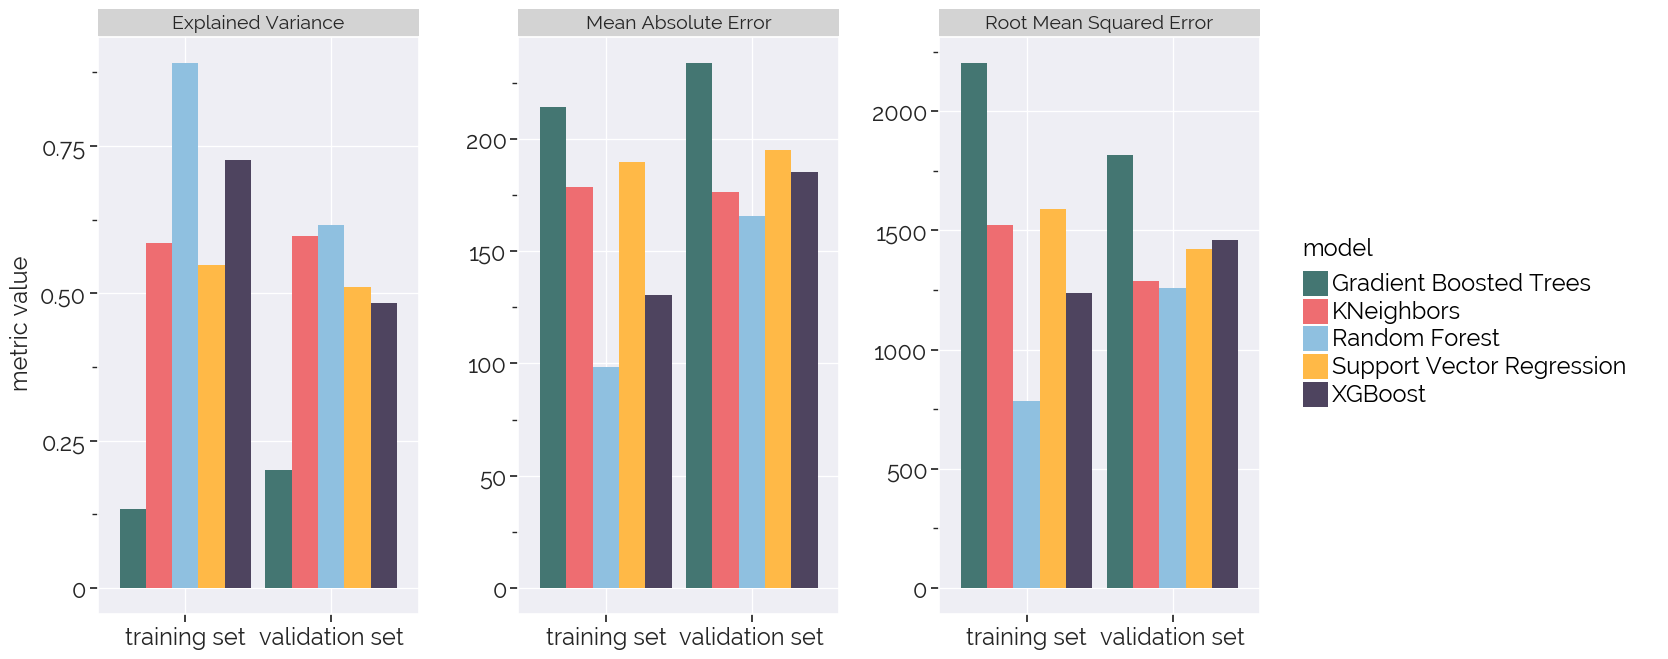

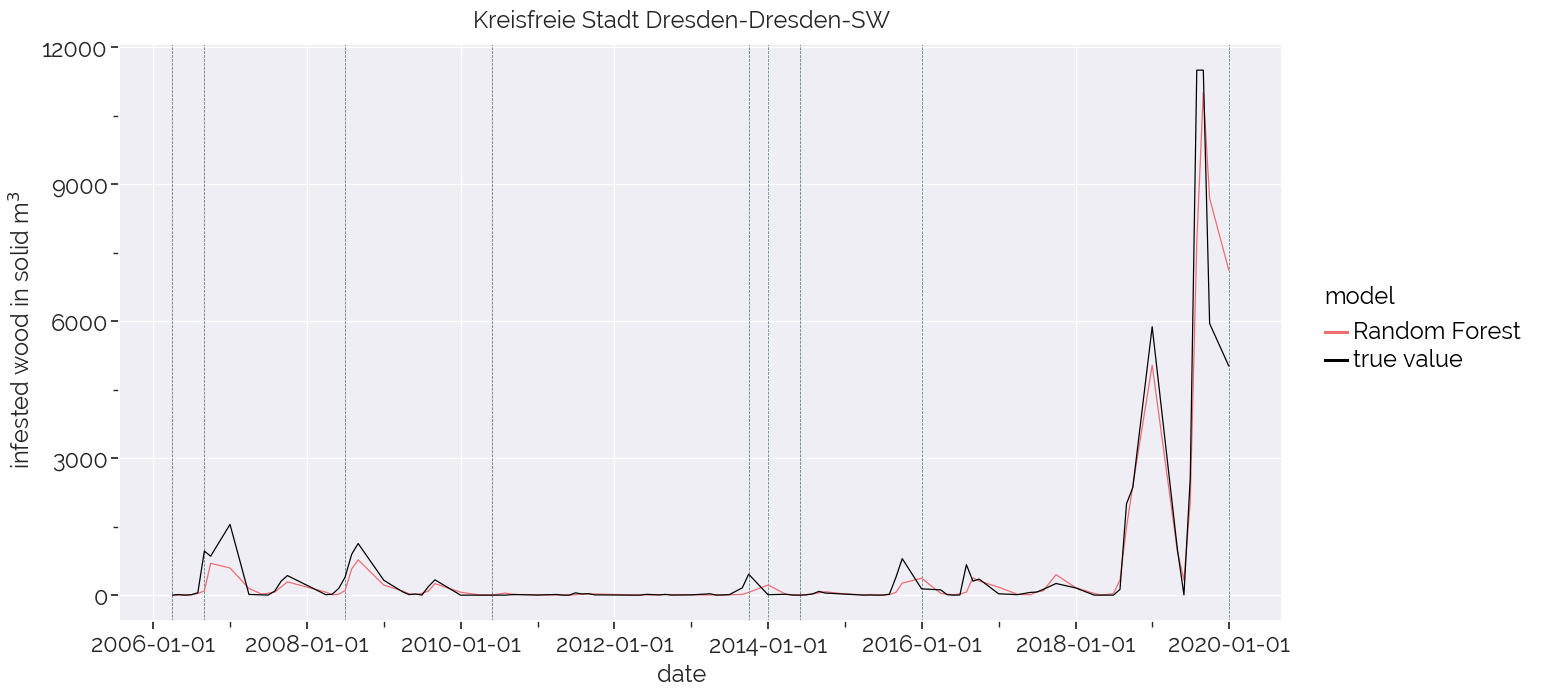

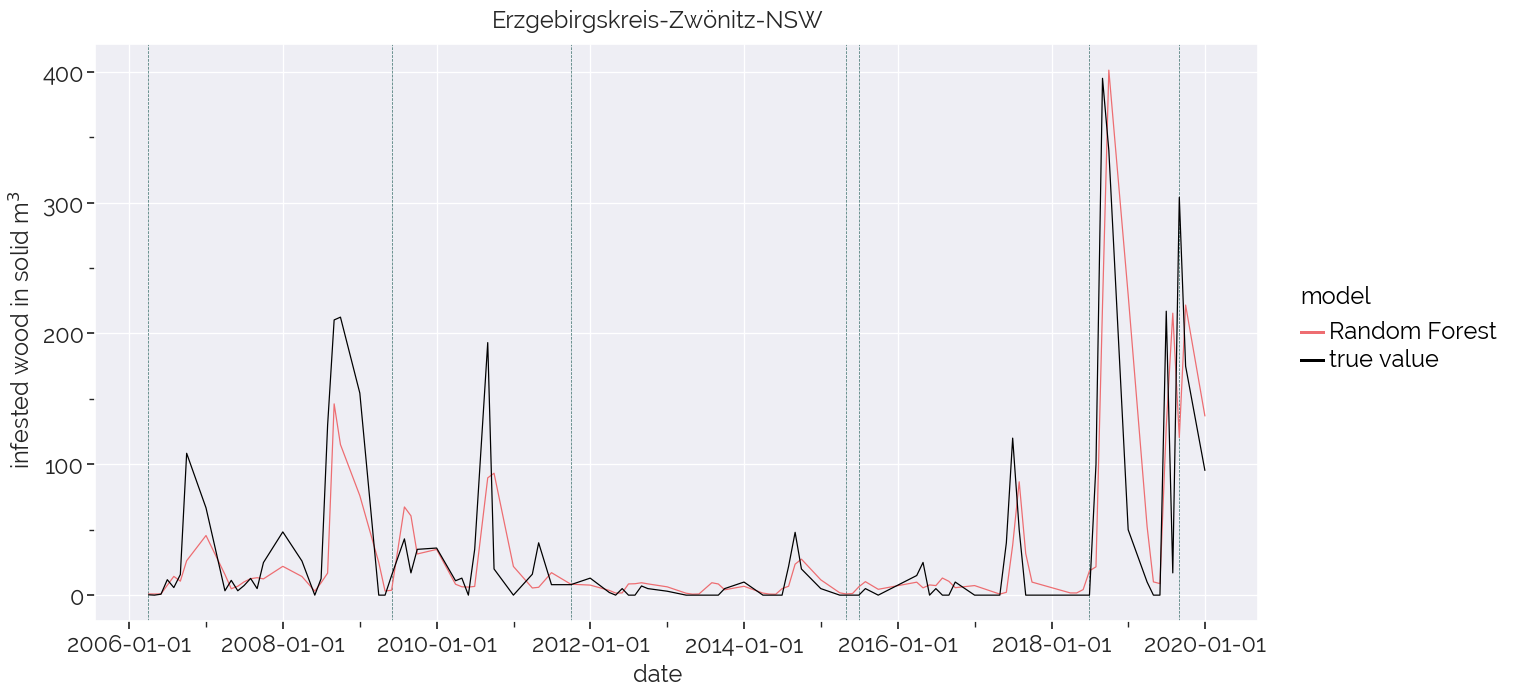

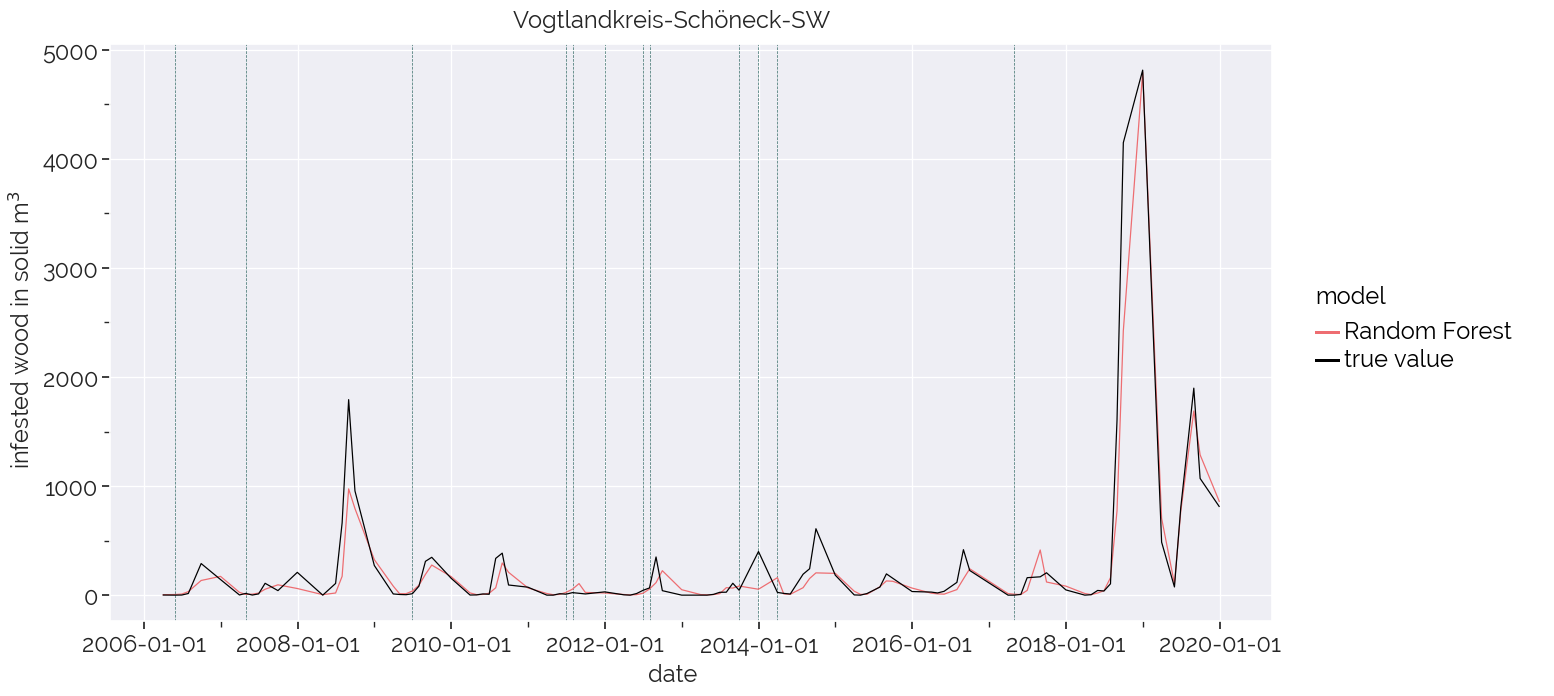

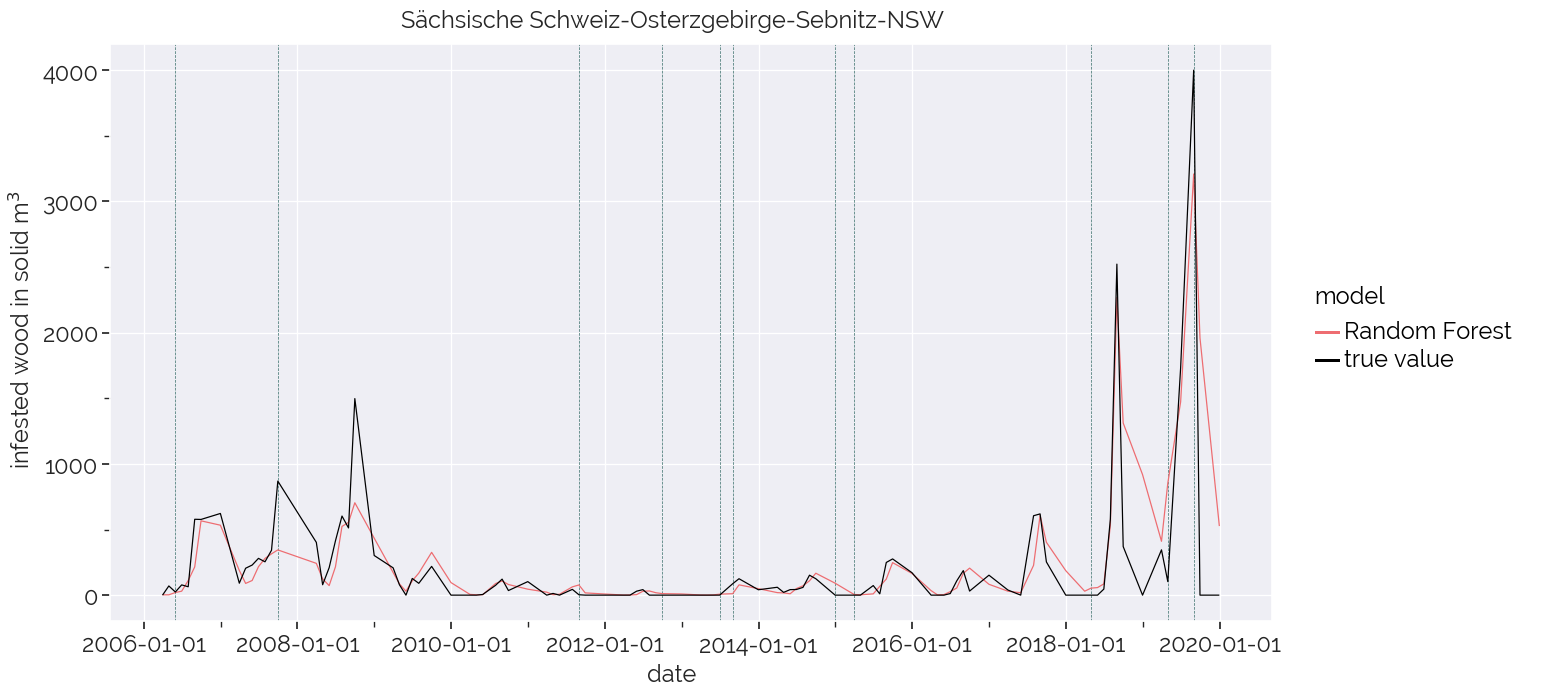

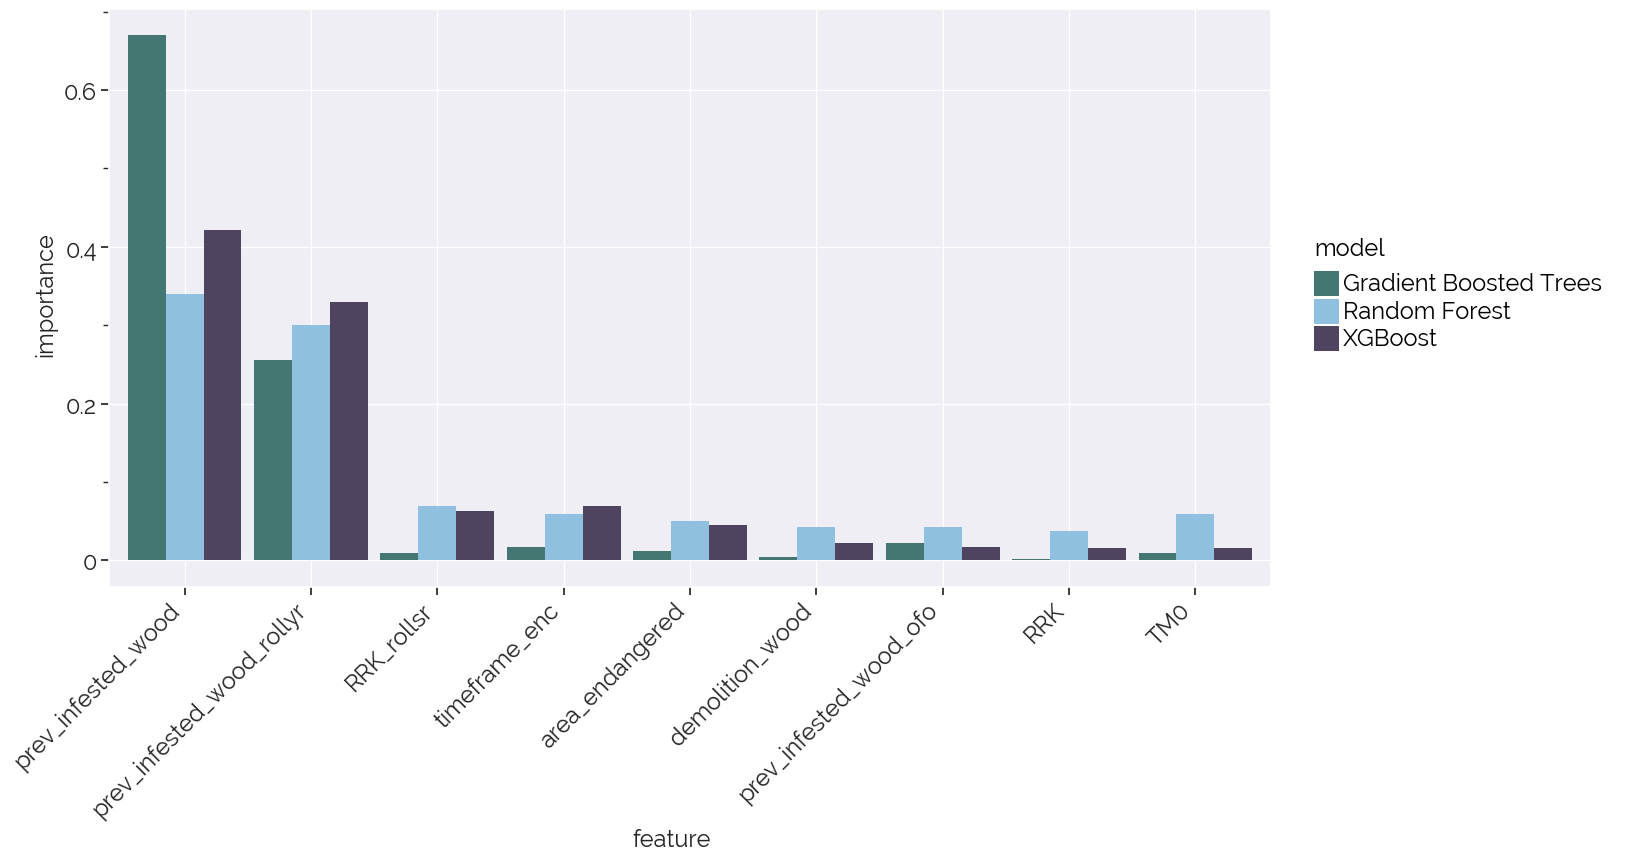

In [58]:
plot_results(fru_results_df, best_models_fru, grid_dict, X_train, X_val, y_train, y_val, r'pred_frugal/')

# 6 Choosing the best model

NOTE: More feature combinations were tested, but none yielded. Not all of them were shown in this notebook due to the iterative nature of the data science life cycle. 

Training set performance for k-Neighbors is perfect since model was trained on the whole dataset it is predicting and the 'weights' hyperparameter was set to 'distance'. This makes this a textbook case of overfitting, since the weighting for each point in the training set will be essentially 1.

The best model was a Random forest of the frugal approach. Let's see the test set scores.

In [59]:
final_model = best_models_fru[1]

y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

print(f'\n\nSummary of test set errors')
print(f'Random Forest: frugal approach:')
print('-------------------------')
print("MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_pred)))
print("RMSE: {:.2f}".format(mean_squared_error(y_test, y_test_pred, squared=False)))
print("Explained Variance: {:.2f}\n".format(explained_variance_score(y_test, y_test_pred)))



Summary of test set errors
Random Forest: frugal approach:
-------------------------
MAE: 141.82
RMSE: 911.83
Explained Variance: 0.62



In [60]:
fru_results_df['final model'] = np.concatenate([y_train_pred, y_val_pred, y_test_pred])    

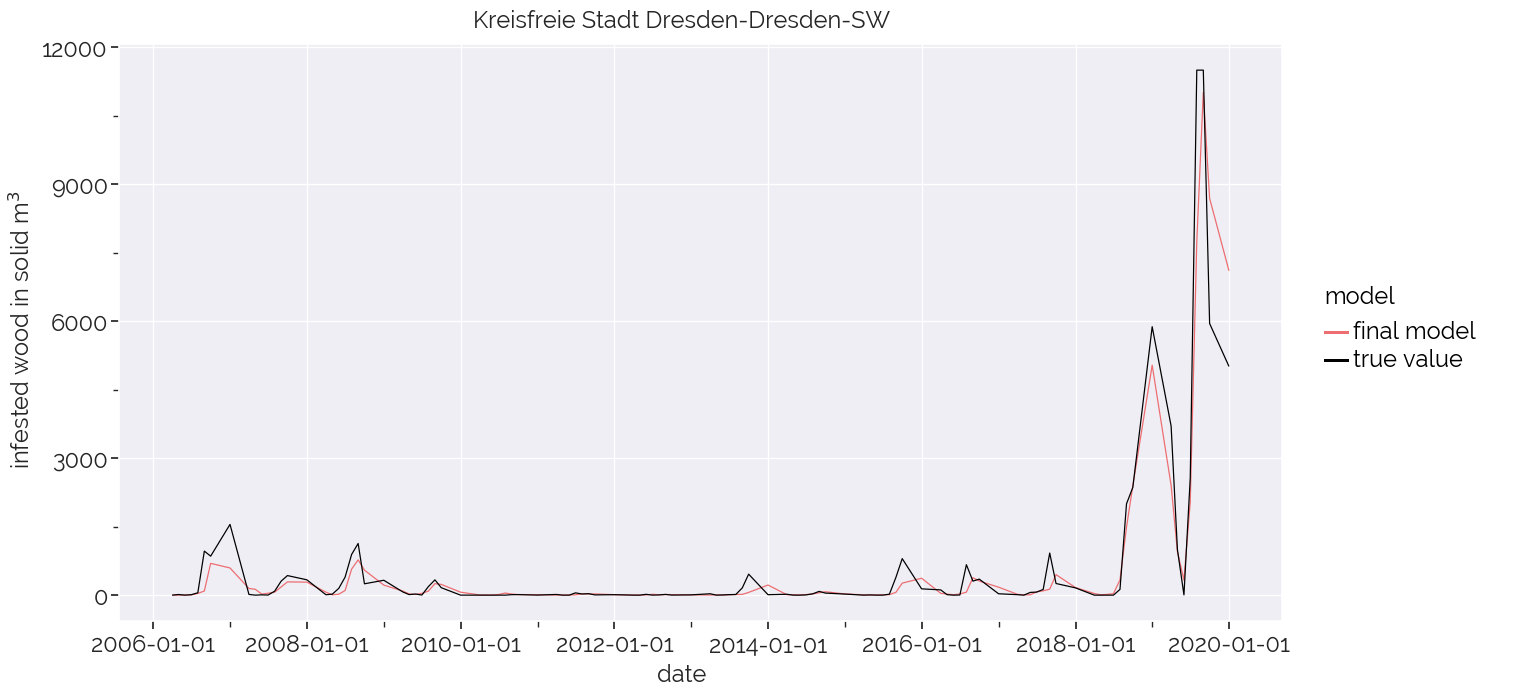

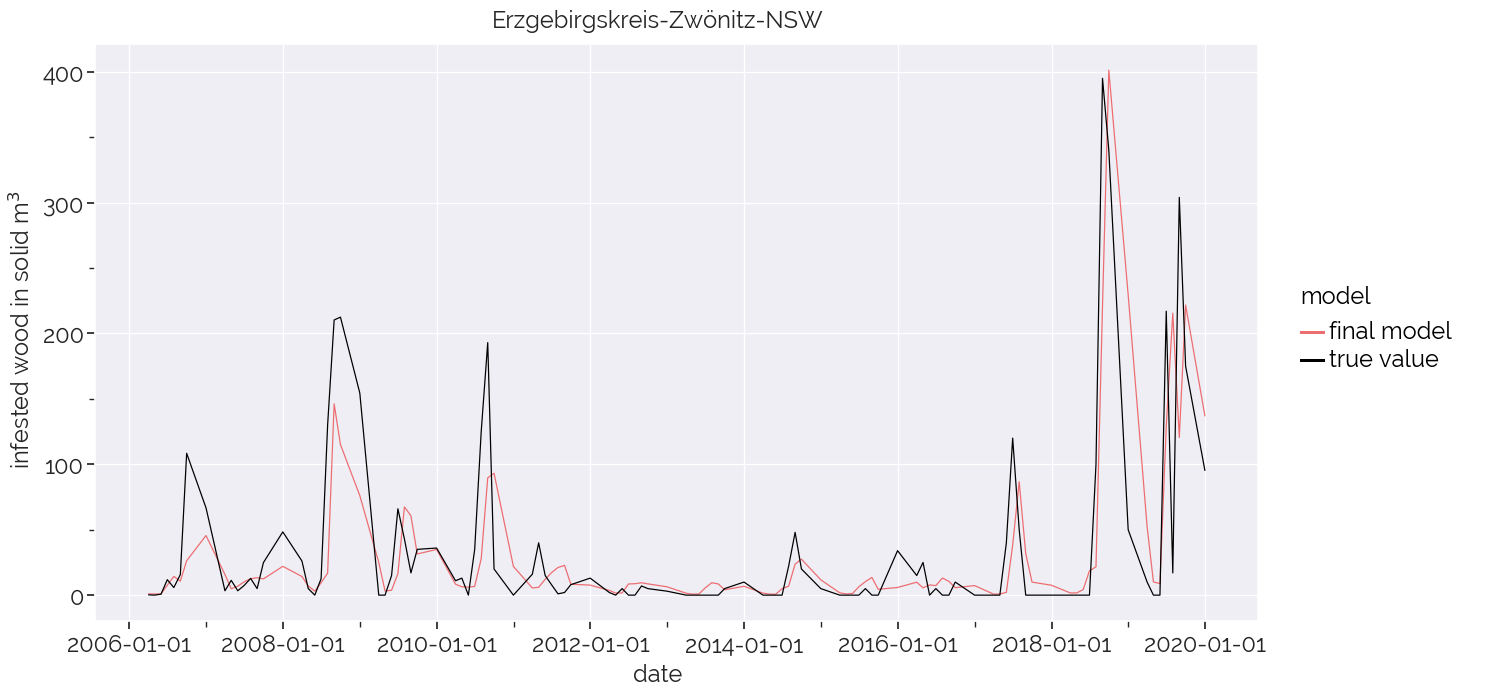

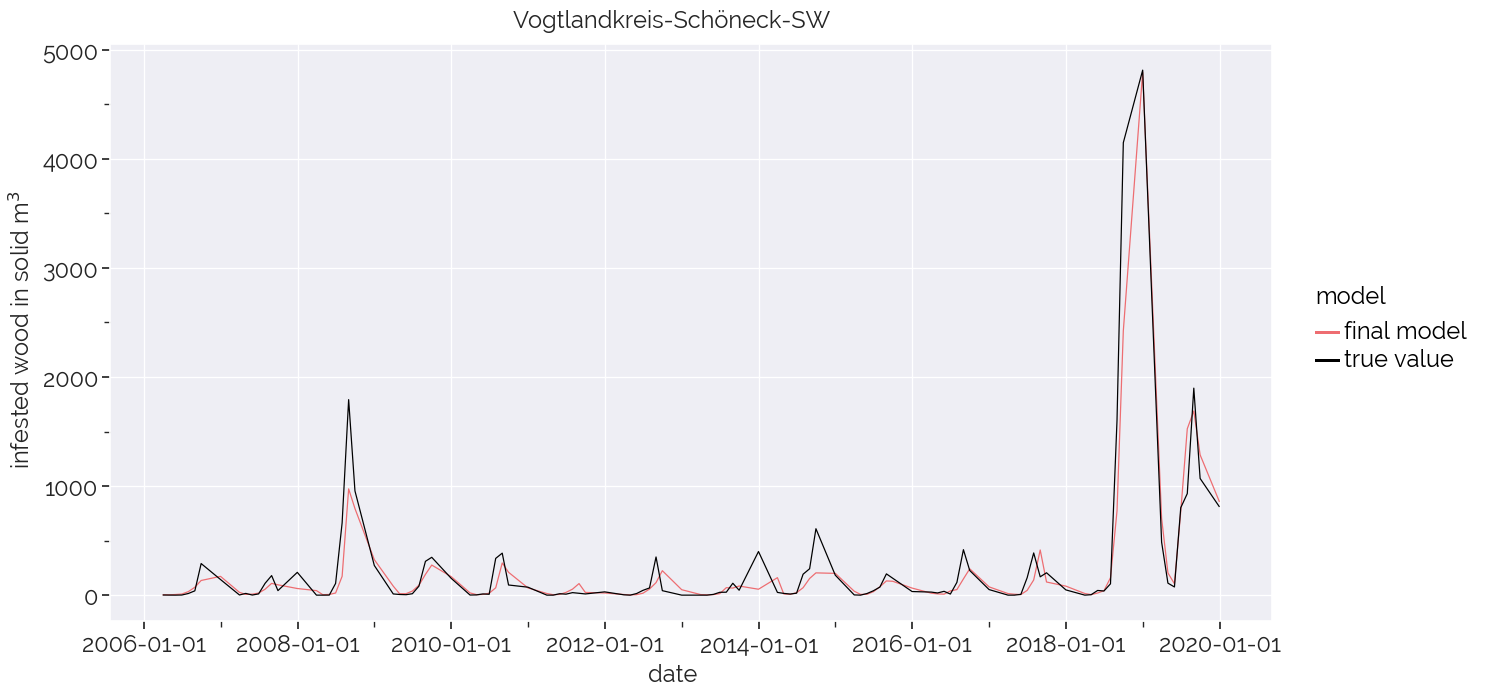

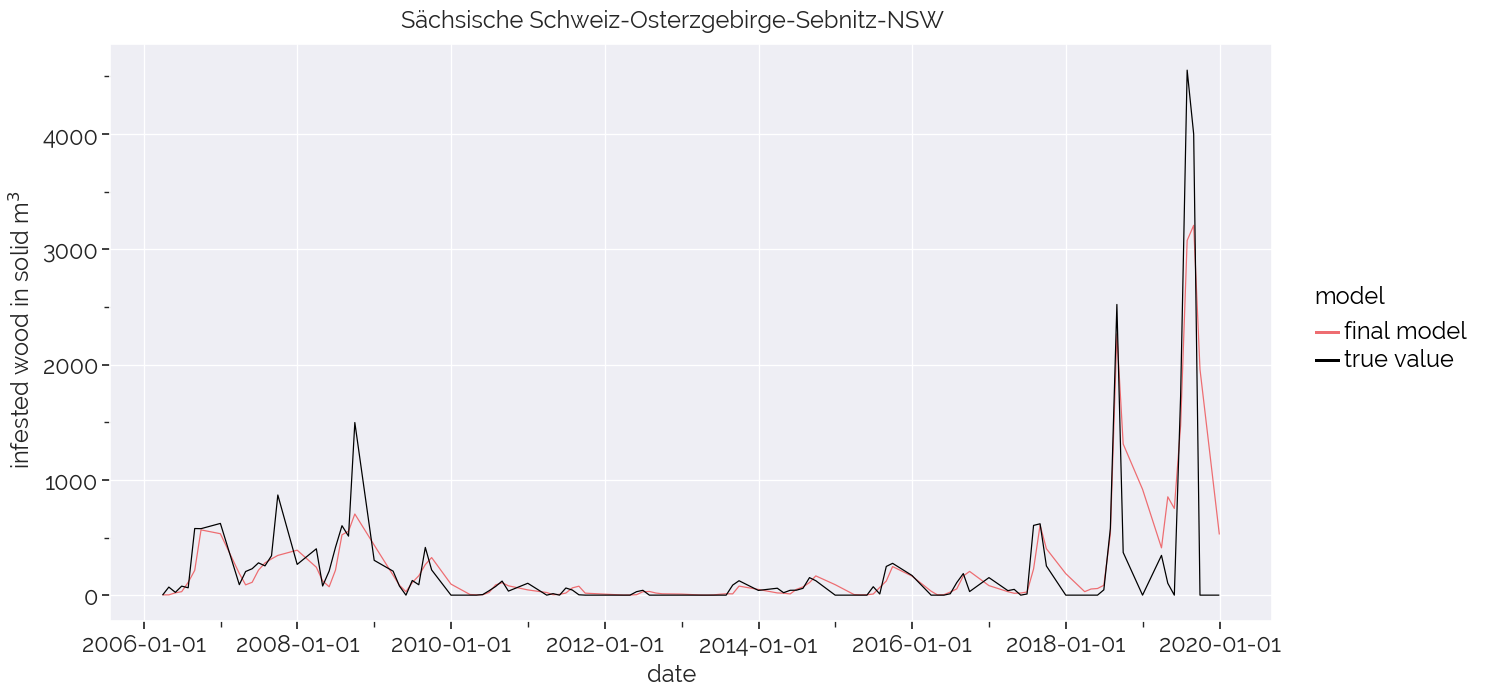

In [61]:
for ID in fru_results_df['id'].unique():
    draw = fru_results_df[fru_results_df['id'] == ID]
    draw = pd.melt(draw, id_vars=['id', 'timestamp', 'set'], value_vars=[
        'true value', 
        'final model', 
        #top_models[1], top_models[2]
    ])
    validation_ts = draw[draw['set'] == 'validation set']['timestamp']
    test_ts = draw[draw['set'] == 'test set']['timestamp']
    
    p=(p9.ggplot(draw)
        + p9.geom_line(p9.aes('timestamp', 'value', color='variable'))
        + p9.scale_color_manual([
            mycolors[1], 
            #mycolors[1], mycolors[2], 
            'black'], name='model')
        + p9.xlab('date') + p9.ylab(r'infested wood in solid m$^3$')
        + p9.labels.ggtitle(ID)
        + mytheme_wide
    )
    p.save(fr'pred_final/{ID}.png', verbose=False)
    
    if ID in [
        'Vogtlandkreis-Schöneck-SW',
        'Sächsische Schweiz-Osterzgebirge-Sebnitz-NSW',
        'Erzgebirgskreis-Zwönitz-NSW',
        'Kreisfreie Stadt Dresden-Dresden-SW'
    ]:
        p.draw()

In [62]:
# save the model to disk
pickle.dump(final_model, open('final_model.pkl', 'wb'))

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_endangered            9515 non-null   float64
 1   timeframe_enc              9515 non-null   float64
 2   prev_infested_wood         9513 non-null   float64
 3   prev_infested_wood_rollyr  9500 non-null   float64
 4   prev_infested_wood_ofo     9513 non-null   float64
 5   RRK                        9515 non-null   float64
 6   TM0                        9515 non-null   float64
 7   demolition_wood            9511 non-null   float64
 8   RRK_rollsr                 9502 non-null   float64
dtypes: float64(9)
memory usage: 743.4 KB
